In [2]:
import matplotlib.pyplot as plt

from scripts import tabular_baselines

import seaborn as sns
import numpy as np

from datasets import load_openml_list, valid_dids_classification, test_dids_classification, open_cc_dids
from scripts.tabular_baselines import *
from scripts.tabular_evaluation import evaluate
from scripts.tabular_metrics import calculate_score, make_ranks_and_wins_table, make_metric_matrix
from scripts import tabular_metrics
from scripts.transformer_prediction_interface import TabPFNClassifier

In [3]:
from notebook_utils import *

In [4]:
%load_ext autoreload

%autoreload 2

# Datasets

In [5]:
from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids, test_dids_classification

cc_valid_datasets_multiclass, cc_valid_datasets_multiclass_df = load_openml_list(open_cc_valid_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)


Number of datasets: 149


# Setting params

In [6]:
import os
eval_positions = [1000]
max_features = 100
bptt = 2000
base_path = os.path.join('.')
overwrite = False
#max_times = [0.5, 1, 15, 30, 60, 60*5, 60*15, 60*60]
#max_times = [1, 15]
max_times = [1, 15, 30, 60, 60 * 5, 60 * 15, 60*60]
metric_used = tabular_metrics.auc_metric
task_type = 'multiclass'

In [7]:
from scripts.distill_mlp import DistilledTabPFNMLP
from tabpfn.transformer_make_model import PermutationsMeta, ForwardMLPModel
from functools import partial
from scripts.tabular_baselines import knn_metric, catboost_metric, transformer_metric, logistic_metric, xgb_metric, random_forest_metric, mlp_metric


# Baseline Evaluation
This section runs baselines and saves results locally.

In [8]:
!mkdir -p {base_path}/results
!mkdir -p {base_path}/results/tabular/
!mkdir -p {base_path}/results/tabular/multiclass/

In [9]:
cc_valid_datasets_multiclass_df['isNumeric'] = (cc_valid_datasets_multiclass_df.NumberOfSymbolicFeatures == 1) & (cc_valid_datasets_multiclass_df.NumberOfInstancesWithMissingValues == 0) * (cc_valid_datasets_multiclass_df.NumberOfFeatures > 4)
name_indexed_dataset = cc_valid_datasets_multiclass_df.set_index("name")

numeric_valid_datasets = [ds for ds in cc_valid_datasets_multiclass if name_indexed_dataset.loc[ds[0]].isNumeric]
len(numeric_valid_datasets)

54

In [10]:
import os
os.environ["LD_LIBRARY_PATH"] = "/anaconda/envs/fresh311/lib:" + os.environ["LD_LIBRARY_PATH"]

In [11]:
from tabpfn.scripts.tabular_evaluation import eval_on_datasets
device = "cpu"
max_times = [1, 5, 15, 60, 5 * 60, 15 * 60]
clf_dict= {
    'knn': knn_metric,
    'rf_new_params': random_forest_metric,
    'xgb': xgb_metric,
    'logistic': logistic_metric,
    'mlp': mlp_metric}

results_baselines = [
    eval_on_datasets('multiclass', model, model_name, numeric_valid_datasets, eval_positions=eval_positions, max_times=max_times,
                     metric_used=metric_used, split_numbers=[1, 2, 3, 4, 5],
                     bptt=bptt, base_path=base_path, device=device)
    for model_name, model in clf_dict.items()
]

model_name  knn


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 1301 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:   21.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


model_name  rf_new_params


[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1429 out of 1620 | elapsed:    1.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


model_name  xgb


[Parallel(n_jobs=-1)]: Done 175 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


model_name  logistic


[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.


model_name  mlp


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:    1.7s finished


In [34]:
from tabpfn.scripts.tabular_evaluation import eval_on_datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier

# transformers don't have max times
import warnings
max_times = [1]
device = "cuda"

model_string = "defaults_k_aggregate_2_batch_128_onehot_classes_multiclass_02_10_2023_23_55_16"
tabpfn_mine =  TabPFNClassifier(device=device, model_string=model_string, epoch=82, N_ensemble_configurations=32)
tabpfn_refactor = TabPFNClassifier(device=device, model_string="vanilla_lr0001_new_05_31_2023_23_16_43", epoch=200, N_ensemble_configurations=32)
tabpfn_refactor_epoch_290 = TabPFNClassifier(device=device, model_string="vanilla_lr0001_new_05_31_2023_23_16_43", epoch=290, N_ensemble_configurations=32)

distilled_tabpfn = DistilledTabPFNMLP(n_epochs=1000, device="cuda", hidden_size=128, n_layers=2, dropout_rate=.1, learning_rate=0.01, model_string=model_string, epoch=82, )

mother_model_string = "models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_65.cpkt"
forward_mlp = PermutationsMeta(ForwardMLPModel(path=mother_model_string))
mothernet_new = PermutationsMeta(ForwardMLPModel(path='models_diff/prior_diff_real_checkpointcontinue_hidden_128_embed_dim_1024_decoder_nhid_2048_nlayer12_lr0003_n_0_epoch_on_exit.cpkt'))
mothernet_big_model_string = "models_diff/prior_diff_real_checkpointwarm_start_depth_18_model_maker_lr0003_multiclass_05_30_2023_22_53_04_n_0_epoch_49.cpkt"
mothernet_big = PermutationsMeta(ForwardMLPModel(path=mothernet_big_model_string))

model_string_post_refactor = "models_diff/prior_diff_real_checkpointmothernet_from_scratch_lr0003_warm_start_continue2_multiclass_05_31_2023_19_21_34_n_0_epoch_94.cpkt"
mothernet_post_refactor = PermutationsMeta(ForwardMLPModel(path=model_string_post_refactor))

model_string_old_reference_config = "reproduce_reference_config_06_02_2023_17_08_59"
old_reference_config = TabPFNClassifier(device=device, model_string=model_string_old_reference_config, epoch="on_exit", N_ensemble_configurations=32)
old_reference_config_epoch_290 = TabPFNClassifier(device=device, model_string=model_string_old_reference_config, epoch=290, N_ensemble_configurations=32)

model_string_reference_config_continue =  "reproduce_reference_config_continue_06_05_2023_17_45_06"
reference_config_continue = TabPFNClassifier(device=device, model_string=model_string_reference_config_continue, epoch="on_exit", N_ensemble_configurations=32)

model_string_reference_config_long = "reproduce_reference_config_try_again_800_epochs_06_07_2023_21_49_10"
reference_config_long = TabPFNClassifier(device=device, model_string=model_string_reference_config_long, epoch="on_exit", N_ensemble_configurations=32)

#mother_of_ensembles = BaggingClassifier(PermutationsMeta(ForwardMLPModel(path=mother_model_string)), max_features=.8, max_samples=.8)
#mother_of_ensembles_again = BaggingClassifier(PermutationsMeta(ForwardMLPModel(path=mother_model_string)), max_features=.5, max_samples=.5)
forward_mlp_scaled = make_pipeline(StandardScaler(), forward_mlp)
distilled_tabpfn_scaled = make_pipeline(StandardScaler(), distilled_tabpfn)

clf_dict= {
    
             'transformer': transformer_metric,
                 'transformer_recompute': transformer_metric,

             'tabpfn_refactor2': partial(transformer_metric, classifier=tabpfn_refactor),
                 'tabpfn_refactor_290': partial(transformer_metric, classifier=tabpfn_refactor_epoch_290),
                 'tabpfn_refactor_reference_config': partial(transformer_metric, classifier=old_reference_config),
                'tabpfn_refactor_reference_config_290': partial(transformer_metric, classifier=old_reference_config_epoch_290),
                'tabpfn_reference_config_continue':  partial(transformer_metric, classifier=reference_config_continue),
                'tabpfn_reference_config_800': partial(transformer_metric, classifier=reference_config_long),


               'tabpfn_mine': partial(transformer_metric, classifier=tabpfn_mine),
                'distill_tabpfn_scaled':  partial(transformer_metric, classifier=distilled_tabpfn_scaled),
       #         'mother_of_ensembles': partial(transformer_metric, classifier=mother_of_ensembles),
       #         'mother_of_ensembles_again': partial(transformer_metric, classifier=mother_of_ensembles_again),

                'mother_net': partial(transformer_metric, classifier=forward_mlp),
                'mothernet_new': partial(transformer_metric, classifier=mothernet_new),
                #'mothernet_big': partial(transformer_metric, classifier=mothernet_big),
                #'mothernet_post_refactor': partial(transformer_metric, classifier=mothernet_post_refactor),
                  }
results_transformers = [
    eval_on_datasets('multiclass', model, model_name, numeric_valid_datasets, eval_positions=eval_positions, max_times=max_times,
                     metric_used=metric_used, split_numbers=[1, 2, 3, 4, 5],
                     bptt=bptt, base_path=base_path, device=device, overwrite=False)
    for model_name, model in clf_dict.items()
]

model_name  transformer


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 294.62it/s]


model_name  transformer_recompute


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 310.62it/s]


model_name  tabpfn_refactor2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 321.31it/s]


model_name  tabpfn_refactor_290


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 332.32it/s]


model_name  tabpfn_refactor_reference_config


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 332.78it/s]


model_name  tabpfn_refactor_reference_config_290


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 334.92it/s]


model_name  tabpfn_reference_config_continue


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 334.45it/s]


model_name  tabpfn_reference_config_800


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [01:01<00:00,  4.37it/s]


model_name  tabpfn_mine


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 329.10it/s]


model_name  distill_tabpfn_scaled


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 334.31it/s]


model_name  mother_net


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 335.42it/s]


model_name  mothernet_new


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 332.00it/s]


In [13]:
# results_baselines = []

In [35]:
flat_results = []
for per_dataset in results_baselines + results_transformers:
    for result in per_dataset:
        row = {}
        for key in ['dataset', 'model', 'mean_metric', 'split', 'max_time']:
            row[key] = result[key]
        best_configs_key, = [k for k in result.keys() if "best_configs" in k]
        if result[best_configs_key][0] is not None:
            row.update(result[best_configs_key][0])
        row['mean_metric'] = float(row["mean_metric"].numpy())
        flat_results.append(row)

results_df = pd.DataFrame(flat_results)

In [36]:
results_df

,dataset,model,mean_metric,split,max_time,best,fit_time,inference_time
0,sonar,knn,0.863095,1,1,{'n_neighbors': 3},0.000334,0.001602
1,sonar,knn,0.878519,2,1,{'n_neighbors': 2},0.000302,0.001538
2,sonar,knn,0.880362,3,1,{'n_neighbors': 3},0.000343,0.001632
3,sonar,knn,0.882168,4,1,{'n_neighbors': 3},0.000626,0.002256
4,sonar,knn,0.902968,5,1,{'n_neighbors': 2},0.000244,0.001069
...,...,...,...,...,...,...,...,...
11335,Touch2,mothernet_new,0.947475,1,1,NaN,0.447886,0.004645
11336,Touch2,mothernet_new,0.962047,2,1,NaN,0.429828,0.004452
11337,Touch2,mothernet_new,0.953566,3,1,NaN,0.438542,0.004427
11338,Touch2,mothernet_new,0.954281,4,1,NaN,0.445876,0.004468


In [37]:
import pickle
with open("results_validation_post_refactor.pickle", "wb") as f:
    pickle.dump(results_baselines + results_transformers, f)

In [38]:
results_df.to_csv("results_validation_post_refactor.csv")

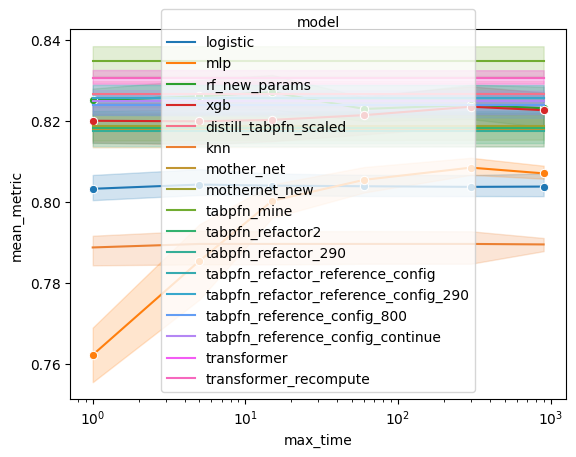

In [39]:
compare_splits = results_df.groupby(["model", "split", "max_time"])['mean_metric'].mean().reset_index()

import seaborn as sns
varies_over_time = ['logistic', 'xgb', 'rf_new_params', 'mlp']
compare_splits_varies = compare_splits[compare_splits.model.isin(varies_over_time)]
compare_splits_fixed = compare_splits[~compare_splits.model.isin(varies_over_time)]

color_palette = sns.color_palette()
# ax = sns.lineplot(data=compare_splits_varies, x="max_time", y="mean_metric", hue="model", errorbar="sd", marker="o", palette=color_palette[:len(varies_over_time)])
ax = sns.lineplot(data=compare_splits_varies, x="max_time", y="mean_metric", hue="model",  marker="o") #, palette=color_palette[:len(varies_over_time)])

compare_splits_fixed_dummy = compare_splits_fixed.copy()
compare_splits_fixed_dummy['max_time'] = compare_splits_varies.max_time.max()
sns.lineplot(data=pd.concat([compare_splits_fixed, compare_splits_fixed_dummy]),
             x="max_time", y="mean_metric", hue="model", ax=ax) #, palette=color_palette[len(varies_over_time):compare_splits.model.nunique()])
#sns.lineplot(data=pd.concat([compare_splits_fixed, compare_splits_fixed_dummy]),
#             x="max_time", y="mean_metric", hue="model", errorbar="sd", ax=ax, palette=color_palette[len(varies_over_time):compare_splits.model.nunique()])
#sns.move_legend(ax, (1.01, 0))
ax.set_xscale("log")

#ax.set_ylim(0.9, 0.95)

In [40]:
average_over_splits = results_df.groupby(["dataset", "model", "max_time"]).mean_metric.mean().reset_index()

In [41]:
best_over_time = average_over_splits.groupby(["dataset", "model"]).mean_metric.max().reset_index()
best_over_time

,dataset,model,mean_metric
0,CPMP-2015-runtime-classification,distill_tabpfn_scaled,0.714914
1,CPMP-2015-runtime-classification,knn,0.700998
2,CPMP-2015-runtime-classification,logistic,0.719434
3,CPMP-2015-runtime-classification,mlp,0.713141
4,CPMP-2015-runtime-classification,mother_net,0.716372
...,...,...,...
913,wisconsin,tabpfn_reference_config_800,0.542875
914,wisconsin,tabpfn_reference_config_continue,0.545454
915,wisconsin,transformer,0.636941
916,wisconsin,transformer_recompute,0.636941


/anaconda/envs/tabpfn/lib/python3.7/site-packages/networkx/convert_matrix.py:685: DeprecationWarning: from_numpy_matrix is deprecated and will be removed in NetworkX 3.0.
Use from_numpy_array instead, e.g. from_numpy_array(A, **kwargs)
  DeprecationWarning,


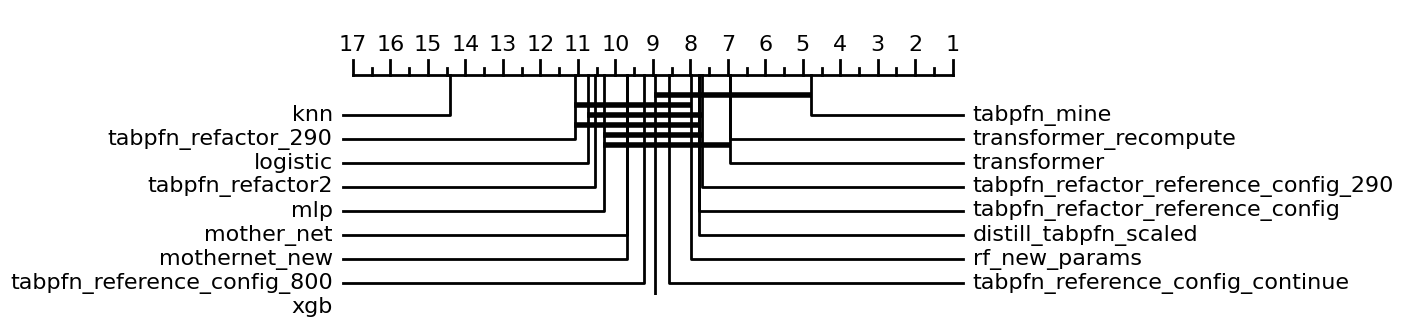

In [42]:
from tabpfn.scripts.critical_differences import draw_cd_diagram

best_over_time.columns = ['dataset_name', 'classifier_name', 'accuracy']
res = draw_cd_diagram(best_over_time, title="OVO ROC AUC");


In [26]:
results_df = results_df.drop_duplicates(subset=["dataset", "model", "split", "max_time"])

In [27]:
results_for_ranking = results_df.pivot(index="max_time", columns=["dataset", "split", "model"], values="mean_metric").ffill()

ranks_per_split_per_dataset = results_for_ranking.stack("model").unstack("max_time").rank(ascending=False)
average_ranks = ranks_per_split_per_dataset.stack("dataset").unstack("model").mean().reset_index(name="mean_rank")
average_ranks

,split,max_time,model,mean_rank
0,1,1,distill_tabpfn_scaled,4.453704
1,1,1,knn,7.509259
2,1,1,logistic,5.546296
3,1,1,mlp,7.675926
4,1,1,mother_net,5.203704
...,...,...,...,...
295,5,900,mothernet_new,5.638889
296,5,900,rf_new_params,4.814815
297,5,900,tabpfn_refactor,5.018519
298,5,900,transformer,4.259259


Text(0.5, 0, 'max time (s)')

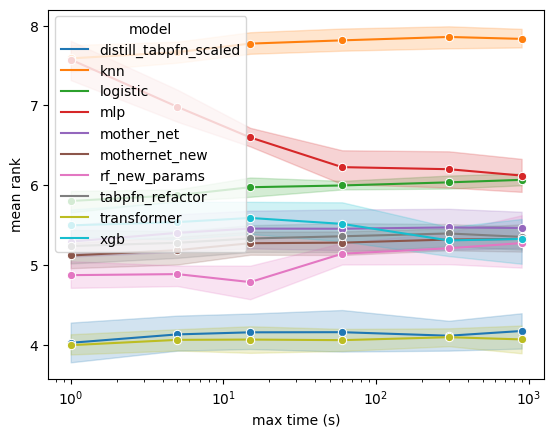

In [30]:
# ax = sns.lineplot(data=average_ranks, x="max_time", y="mean_rank", hue="model", errorbar="sd", marker="o")
ax = sns.lineplot(data=average_ranks, x="max_time", y="mean_rank", hue="model", marker="o")
ax.set_xscale("log")
# sns.move_legend(ax, (1.01, 0))
ax.set_ylabel("mean rank")
ax.set_xlabel("max time (s)")